In [55]:
# Importing Relevant Libraries
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [56]:
# Defining the time-range for the dataset
time_range = ('2008-01-01', '2022-12-30')

# Pulling AMZN stock data for the specified time range
df = yf.download('GOOGL', time_range[0], time_range[1])

[*********************100%***********************]  1 of 1 completed


In [57]:
df = df.reset_index()

# Dropping columns 
df = df.drop(['Date', 'Adj Close'], axis=1)

In [58]:
# Calculating the moving average of the previous 100/200 days
moving_average_100 = df.Close.rolling(100).mean()
moving_average_200 = df.Close.rolling(200).mean()

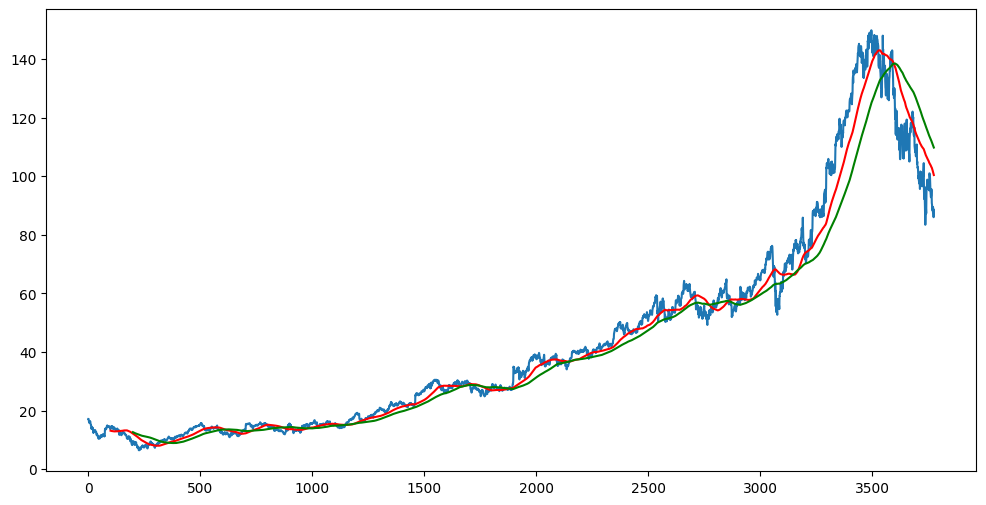

In [59]:
# Observing trends for the moving averages and the closing prices
plt.figure(figsize=(12,6))

plt.plot(df.Close)
plt.plot(moving_average_100, 'r')
plt.plot(moving_average_200, 'g')

In [60]:
df.shape

(3776, 5)

In [61]:
# Splitting the dataset into a training and testing set(70/30 split)
training_set, testing_set = pd.DataFrame(df['Close'][0:int(len(df)*0.70)]), pd.DataFrame(df['Close'][int(len(df)*0.70): int(len(df))])

In [62]:
print(training_set.shape)
print(testing_set.shape)

(2643, 1)
(1133, 1)


In [63]:
# Scaling the data down to a feature range between 0 and 1
min_mx_scaler = MinMaxScaler(feature_range=(0,1))
training = min_mx_scaler.fit_transform(training_set)

# Prediction based on n-previous data points (feature extraction)
x_train, y_train = [], []

steps = 100
rows = training.shape[0]

# N-Steps(100) X-train is the previous 100 days(the features used to predict y_train)
for row in range(steps, rows):
  x_train.append(training[row-steps: row])
  y_train.append(training[row, 0]) # 101st day price

x_train, y_train = np.array(x_train), np.array(y_train)

In [64]:
x_train.shape

(2543, 100, 1)

In [65]:
# LSTM
lstm_model = Sequential() # Sequential Model

# Using ReLU for activation function to account for non-linear dependencies
# Input shape is defined as the columns representing the previous one-hundred days as well as one to account for the closing price column
lstm_model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (x_train.shape[1],1)))

# Drop out layer to prevent over-fitting
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
lstm_model.add(Dropout(0.3))

lstm_model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
lstm_model.add(Dropout(0.4))

lstm_model.add(LSTM(units = 120, activation = 'relu'))
lstm_model.add(Dropout(0.5))

# Output layer
lstm_model.add(Dense(units=1))

lstm_model

In [66]:
# Adam Optimizer and MSE for loss function
lstm_model.compile(optimizer='adam', loss = 'mean_squared_error')
lstm_model.fit(x_train, y_train, epochs=50) # Training for 50 epochs

Epoch 1/50
80/80 [==============================] - 21s 210ms/step - loss: 0.0258
Epoch 2/50
80/80 [==============================] - 18s 227ms/step - loss: 0.0061
Epoch 3/50
80/80 [==============================] - 17s 209ms/step - loss: 0.0048
Epoch 4/50
80/80 [==============================] - 17s 209ms/step - loss: 0.0049
Epoch 5/50
80/80 [==============================] - 17s 218ms/step - loss: 0.0045
Epoch 6/50
80/80 [==============================] - 17s 210ms/step - loss: 0.0040
Epoch 7/50
80/80 [==============================] - 18s 219ms/step - loss: 0.0042
Epoch 8/50
80/80 [==============================] - 17s 211ms/step - loss: 0.0040
Epoch 9/50
80/80 [==============================] - 17s 218ms/step - loss: 0.0039
Epoch 10/50
80/80 [==============================] - 17s 211ms/step - loss: 0.0038
Epoch 11/50
80/80 [==============================] - 17s 210ms/step - loss: 0.0031
Epoch 12/50
80/80 [==============================] - 17s 217ms/step - loss: 0.0031
Epoch 13/50
8

In [67]:
lstm_model.save('lstm_model.h5')

In [68]:
past_data_for_pred = training_set.tail(100)

new_df = past_data_for_pred.append(testing_set, ignore_index = True)

<ipython-input-68-e3394acdbf50>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = past_data_for_pred.append(testing_set, ignore_index = True)


In [69]:
data = min_mx_scaler.fit_transform(new_df)

In [70]:
x_test, y_test = [], []

for i in range(steps, data.shape[0]):
  x_test.append(data[i-steps: i])
  y_test.append(data[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)

In [71]:
# Predictions on testing data
y_pred = lstm_model.predict(x_test)

36/36 [==============================] - 2s 57ms/step


In [72]:
# Scaling the data back up by the same factor we scaled it down by
scale = 1/min_mx_scaler.scale_[0]

y_pred *= scale
y_test *= scale

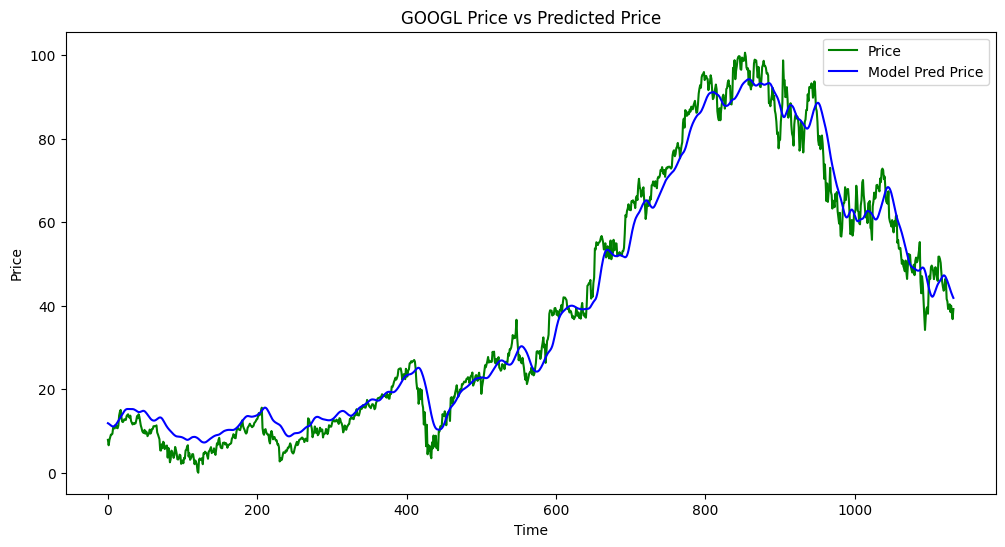

In [73]:
# Plot the original price vs the predicted price over the time-range we defined earlier for AMZN
plt.figure(figsize=(12,6))

plt.title('GOOGL Price vs Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')

plt.plot(y_test, 'g', label = "Price")
plt.plot(y_pred, 'b', label = 'Model Pred Price')

plt.legend()